## CLI 기반 트레이딩 백테스트

Reference: https://data.oecd.org/leadind/composite-leading-indicator-cli.htm  
Reference: https://m.blog.naver.com/sinjeongcc/221277358598

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

%matplotlib inline

import redis

cache_ip = '198.13.60.78'
cache_pw = 'da56038fa453c22d2c46e83179126e97d4d272d02ece83eb83a97357e842d065'

r = redis.StrictRedis(host=cache_ip, port=6379, password=cache_pw)

# redis keys
KOSPI_INDEX = 'I.001_INDEX'
KOSPI_LEVERAGE = '122630_OHLCV' # 코스피 2배 레버리지
KODEX_INVERSE = '114800_OHLCV' # 코스피 인버스
KODEX_INVERSE_LEVERAGE = '252670_OHLCV' # KODEX 200선물인버스2X
BOND = '114260_OHLCV' # KODEX 국고채3년

# 지수 데이터
kp = pd.read_msgpack(r.get(KOSPI_INDEX))
# ETF 데이터
kp_lvg = pd.read_msgpack(r.get(KOSPI_LEVERAGE))
kp_inv = pd.read_msgpack(r.get(KODEX_INVERSE))
kp_inv_lvg = pd.read_msgpack(r.get(KODEX_INVERSE_LEVERAGE))
bond = pd.read_msgpack(r.get(BOND))

In [2]:
# ETF 가격 정보 모두 합치기
kp_prc = kp.set_index('date')['cls_prc']
kp_lvg_prc = kp_lvg.set_index('date')['adj_prc']
kp_inv_prc = kp_inv.set_index('date')['adj_prc']
kp_inv_lvg_prc = kp_inv_lvg.set_index('date')['adj_prc']
bond_prc = bond.set_index('date')['adj_prc']

df = pd.concat([kp_prc, kp_lvg_prc, kp_inv_prc, kp_inv_lvg_prc, bond_prc], axis=1)
df.index = pd.to_datetime(df.index)
df.columns = ['KP', 'KP Leverage', 'KP Inverse', 'KP Inverse Leverage', 'Bond']

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
# 1개월 데이터로 수정
df_m = df.resample('M').last()
df_m.index = df_m.index.to_period('M') # index의 date에서 year과 month만 나오도록 수정

In [4]:
df_m.head()

,KP,KP Leverage,KP Inverse,KP Inverse Leverage,Bond
2013-01,1961.94,12315,7575,NaN,48437
2013-02,2026.49,13290,7285,NaN,48742
2013-03,2004.89,12740,7435,NaN,49034
2013-04,1963.95,11935,7670,NaN,49129
2013-05,2001.05,12415,7515,NaN,48836


In [5]:
### csv (comma separated values) 파일 읽어오는 방법
import os

# 우선 폴더 내부에 있는 파일들 프린트해보기
os.listdir()

['기본이론 [Day 2] - Money Management.ipynb',
 '005930.xls',
 '.DS_Store',
 'Composite Leading Indicator (CLI).ipynb',
 '수급분석툴.ipynb',
 '리스크관리툴.ipynb',
 'marketsignal_bt.csv',
 'README.md',
 'sd_bt.csv',
 'GAA.ipynb',
 '.gitignore',
 '마켓시그널툴.ipynb',
 '기본이론 [Day 1] - Risk.ipynb',
 'cli.csv',
 '기본이론 [Day 3] - Portfolio Management.ipynb',
 '.ipynb_checkpoints',
 '기본이론 [Day 0] - Statistics.ipynb',
 '.git']

In [6]:
# cli.csv 파일을 열어본다
cli = pd.read_csv('cli.csv')
cli.head() # 상위 5줄 프린트

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,GBR,CLI,AMPLITUD,LTRENDIDX,M,2004-01,100.6680,NaN
1,GBR,CLI,AMPLITUD,LTRENDIDX,M,2004-02,100.7777,NaN
2,GBR,CLI,AMPLITUD,LTRENDIDX,M,2004-03,100.8075,NaN
3,GBR,CLI,AMPLITUD,LTRENDIDX,M,2004-04,100.7725,NaN
4,GBR,CLI,AMPLITUD,LTRENDIDX,M,2004-05,100.6897,NaN


In [7]:
# 불러온 location 정보들을 확인한다
locations = list(set(cli['LOCATION'])) # set으로 바꿔서 유니크한 값들만 빼낸 후 리스트로 변환한다
locations

['CHN', 'GBR', 'JPN', 'OECD', 'G-7', 'USA', 'EA19', 'KOR']

In [8]:
jpn_cli = cli[cli['LOCATION'] == 'JPN'] # 일본
ea19_cli = cli[cli['LOCATION'] == 'EA19'] # EA 19개 국가
g7_cli = cli[cli['LOCATION'] == 'G-7'] # G-7 국가들
kor_cli = cli[cli['LOCATION'] == 'KOR'] # 한국
uk_cli = cli[cli['LOCATION'] == 'GBR'] # 영국
us_cli = cli[cli['LOCATION'] == 'USA'] # 미국
chn_cli = cli[cli['LOCATION'] == 'CHN'] # 중국
oecd_cli = cli[cli['LOCATION'] == 'OECD'] # OECD 국가들

# 금방 만든 모든 데이터에 루프를 돌려서 필요한 데이터만 정리하여 남기기
for dataframe in [jpn_cli, ea19_cli, g7_cli, kor_cli, uk_cli, us_cli, chn_cli, oecd_cli]:
    dataframe.set_index('TIME', inplace=True) # index를 날짜로 바꾸기
    dataframe.index = pd.to_datetime(dataframe.index).to_period('M') # datetime 형식으로 변환하고 year과 month만 보이게 수정
    dataframe.drop(['LOCATION', 'INDICATOR', 'SUBJECT', 'MEASURE', 'FREQUENCY', 'Flag Codes'], axis=1, inplace=True) # 필요없는 열은 모두 제거

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [13]:
# 날짜를 2013년부터로 바꾸기
us_cli_df = us_cli['2013':]

In [21]:
data = pd.concat([df_m, us_cli_df], axis=1)
data.rename(columns={'Value': 'US CLI'}, inplace=True)

In [26]:
# 코스피랑 CLI 데이터만 들고오기
bt_data = data[['KP', 'US CLI']]

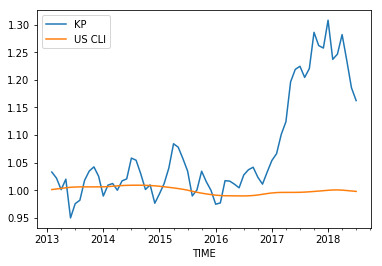

In [28]:
(1 + bt_data.pct_change()).cumprod().plot()
plt.show()

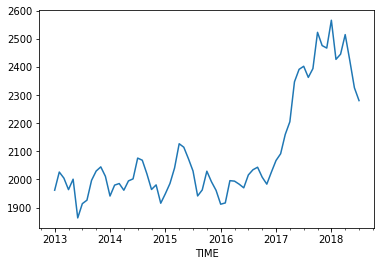

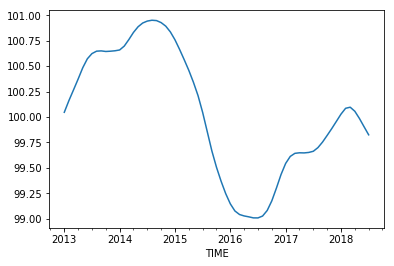

In [31]:
bt_data['KP'].plot()
plt.show()

bt_data['US CLI'].plot()
plt.show()

In [42]:
bt_data

,KP,US CLI,CLI scaled,CLI scaled MA Short,CLI scaled MA Long
TIME,,,,,
2013-01,1961.94,100.04580,0.534285,NaN,NaN
2013-02,2026.49,100.16080,0.593465,NaN,NaN
2013-03,2004.89,100.26610,0.647652,0.591801,NaN
2013-04,1963.95,100.37260,0.702457,0.647858,NaN
2013-05,2001.05,100.48360,0.759578,0.703229,0.647487
2013-06,1863.32,100.57190,0.805017,0.755684,0.701634
2013-07,1914.03,100.62300,0.831314,0.798636,0.749204
2013-08,1926.36,100.64680,0.843561,0.826631,0.788385
2013-09,1996.96,100.64950,0.844950,0.839942,0.816884


In [79]:
# 상승하면 다음 달 코스피 매수, 하락하면 다음 달 코스피 매도
bt_data['CLI Change'] = bt_data['US CLI'].diff()
bt_data['KP Return'] = bt_data['KP'].pct_change()
bt_data['KP Buy'] = (bt_data['CLI Change'].shift(1) > 0) * 1
bt_data['Portfolio Return'] = (bt_data['KP Return'] * bt_data['KP Buy']).fillna(0)
yc = bt_data['Portfolio Return']

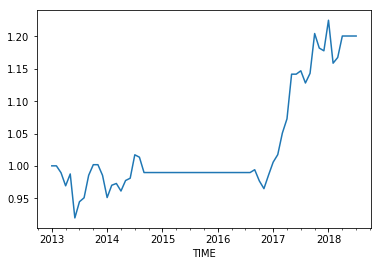

0.03726570100446125

In [82]:
yc_cum = (1 + yc).cumprod()
return_value = yc_cum.iloc[-1] - yc_cum.iloc[0]

yc_cum.plot()
plt.show()

(1 + return_value) ** (1/5) - 1

In [67]:
### 트렌드 고려한 전략

In [83]:
bt_data['CLI MA Short'] = bt_data['US CLI'].rolling(3).mean()
bt_data['CLI MA Long'] = bt_data['US CLI'].rolling(5).mean()
bt_data['KP Hold'] = (bt_data['CLI MA Short'] > bt_data['CLI MA Long']).shift(1) * 2
bt_data['KP Trend Buy'] = ((bt_data['KP Buy'] + bt_data['KP Hold']) >= 2) * 1
bt_data['Trend Portfolio Return'] = (bt_data['KP Return'] * bt_data['KP Trend Buy']).fillna(0)
yc = bt_data['Trend Portfolio Return']

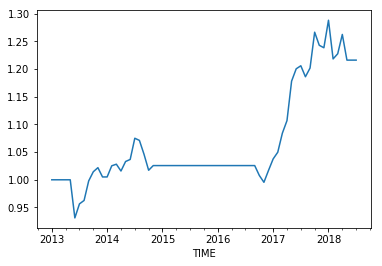

0.039899876578220805

In [85]:
yc_cum = (1 + yc).cumprod()
return_value = yc_cum.iloc[-1] - yc_cum.iloc[0]

yc_cum.plot()
plt.show()

(1 + return_value) ** (1/5) - 1

In [95]:
### 레버리지로 백테스팅
bt_data = data[['KP Leverage', 'KP Inverse', 'US CLI']]

In [96]:
bt_data.head()

,KP Leverage,KP Inverse,US CLI
TIME,,,
2013-01,12315,7575,100.0458
2013-02,13290,7285,100.1608
2013-03,12740,7435,100.2661
2013-04,11935,7670,100.3726
2013-05,12415,7515,100.4836


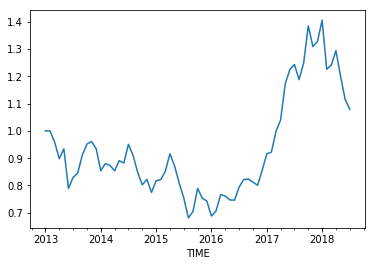

0.015324425532640129

In [100]:
# 레버리지 + 인버스 전략
bt_data['CLI Change'] = bt_data['US CLI'].diff()
bt_data['KP Return'] = bt_data['KP Leverage'].pct_change()
bt_data['KP Inverse Return'] = bt_data['KP Inverse'].pct_change()
bt_data['KP Buy'] = (bt_data['CLI Change'].shift(1) > 0) * 1
bt_data['KP Inverse Buy'] = (bt_data['CLI Change'].shift(1) <= 0) * 1
bt_data['Portfolio Return'] = (bt_data['KP Return'] * bt_data['KP Buy']).fillna(0)
bt_data['Inverse Portfolio Return'] = (bt_data['KP Return'] * bt_data['KP Inverse Buy']).fillna(0)
yc = bt_data['Portfolio Return'] + bt_data['Inverse Portfolio Return']

yc_cum = (1 + yc).cumprod()
return_value = yc_cum.iloc[-1] - yc_cum.iloc[0]

yc_cum.plot()
plt.show()

(1 + return_value) ** (1/5) - 1

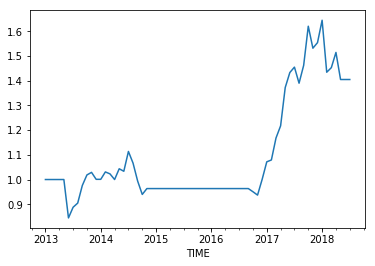

0.070366323697173

In [90]:
bt_data['CLI MA Short'] = bt_data['US CLI'].rolling(3).mean()
bt_data['CLI MA Long'] = bt_data['US CLI'].rolling(5).mean()
bt_data['KP Hold'] = (bt_data['CLI MA Short'] > bt_data['CLI MA Long']).shift(1) * 2
bt_data['KP Trend Buy'] = ((bt_data['KP Buy'] + bt_data['KP Hold']) >= 2) * 1
bt_data['Trend Portfolio Return'] = (bt_data['KP Return'] * bt_data['KP Trend Buy']).fillna(0)
yc = bt_data['Trend Portfolio Return']

yc_cum = (1 + yc).cumprod()
return_value = yc_cum.iloc[-1] - yc_cum.iloc[0]

yc_cum.plot()
plt.show()

(1 + return_value) ** (1/5) - 1

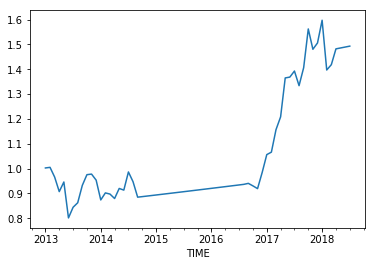

0.0831403400233659

In [106]:
bt_data['CLI Change'] = bt_data['US CLI'].diff()
bt_data['KP Return'] = bt_data['KP Leverage'].pct_change()
bt_data['KP Buy'] = (bt_data['CLI Change'].shift(1) > 0) * 1
bt_data['MMF Buy'] = (bt_data['CLI Change'].shift(1) <= 0) * 1
bt_data['Portfolio Return'] = (bt_data['KP Return'] * bt_data['KP Buy']).fillna(0)
mmf_return = 1.03 ** (1/12) - 1
bt_data['MMF Return'] = [mmf_return] * len(bt_data)

bt_data['MMF Portfolio Return'] = bt_data['Portfolio Return'] + bt_data['MMF Return']
yc = bt_data['MMF Portfolio Return']

yc_cum = (1 + yc).cumprod()
return_value = yc_cum.iloc[-1] - yc_cum.iloc[0]

yc_cum.plot()
plt.show()

(1 + return_value) ** (1/5) - 1

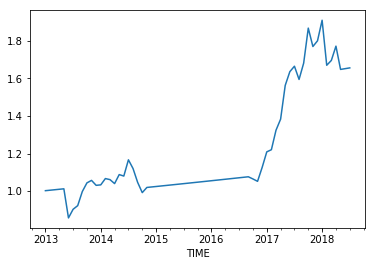

0.105809785781382

In [107]:
bt_data['CLI Change'] = bt_data['US CLI'].diff()
bt_data['KP Return'] = bt_data['KP Leverage'].pct_change()
bt_data['KP Buy'] = (bt_data['CLI Change'].shift(1) > 0) * 1
bt_data['MMF Buy'] = (bt_data['CLI Change'].shift(1) <= 0) * 1
bt_data['Portfolio Return'] = (bt_data['KP Return'] * bt_data['KP Buy']).fillna(0)
mmf_return = 1.03 ** (1/12) - 1
bt_data['MMF Return'] = [mmf_return] * len(bt_data)

bt_data['CLI MA Short'] = bt_data['US CLI'].rolling(3).mean()
bt_data['CLI MA Long'] = bt_data['US CLI'].rolling(5).mean()
bt_data['KP Hold'] = (bt_data['CLI MA Short'] > bt_data['CLI MA Long']).shift(1) * 2
bt_data['KP Trend Buy'] = ((bt_data['KP Buy'] + bt_data['KP Hold']) >= 2) * 1
bt_data['Trend Portfolio Return'] = (bt_data['KP Return'] * bt_data['KP Trend Buy']).fillna(0)

bt_data['MMF Trend Portfolio Return'] = bt_data['Trend Portfolio Return'] + bt_data['MMF Return']
yc = bt_data['MMF Trend Portfolio Return']

yc_cum = (1 + yc).cumprod()
return_value = yc_cum.iloc[-1] - yc_cum.iloc[0]

yc_cum.plot()
plt.show()

(1 + return_value) ** (1/5) - 1

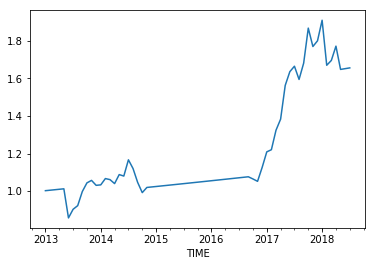

0.105809785781382

In [111]:
bt_data['CLI Change'] = bt_data['US CLI'].diff()
bt_data['KP Return'] = bt_data['KP Leverage'].pct_change()
bt_data['KP Buy'] = (bt_data['CLI Change'].shift(1) > 0) * 1
bt_data['MMF Buy'] = (bt_data['CLI Change'].shift(1) <= 0) * 1
bt_data['Portfolio Return'] = (bt_data['KP Return'] * bt_data['KP Buy']).fillna(0)
mmf_return = 1.03 ** (1/12) - 1
bt_data['MMF Return'] = [mmf_return] * len(bt_data)

bt_data['CLI MA Short'] = bt_data['US CLI'].rolling(3).mean()
bt_data['CLI MA Long'] = bt_data['US CLI'].rolling(5).mean()
bt_data['KP Hold'] = (bt_data['CLI MA Short'] > bt_data['CLI MA Long']).shift(1) * 2
bt_data['KP Trend Buy'] = ((bt_data['KP Buy'] + bt_data['KP Hold']) >= 2) * 1
bt_data['Trend Portfolio Return'] = (bt_data['KP Return'] * bt_data['KP Trend Buy']).fillna(0)

bt_data['MMF Trend Portfolio Return'] = bt_data['Trend Portfolio Return'] + bt_data['MMF Return']
yc = bt_data['MMF Trend Portfolio Return']

yc_cum = (1 + yc).cumprod()
return_value = yc_cum.iloc[-1] - yc_cum.iloc[0]

yc_cum.plot()
plt.show()

(1 + return_value) ** (1/5) - 1